In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**THIS PART FOCUSES ON THE PER LABEL METRICS, F1/PRECISION/RECALL**

In [6]:
import pickle, pathlib, numpy as np, pandas as pd
from sklearn.metrics import precision_recall_fscore_support

scenario_pkls = [
    ("DistilBERT MFRC→MFRC", "/content/drive/MyDrive/test_results_distilbert_mfrc_mfrc_split.pkl"),
    ("DistilBERT MFTC→MFTC", "/content/drive/MyDrive/test_results_distilbert_mftc_mftc_split.pkl"),
    ("BERT MFRC→MFRC",       "/content/drive/MyDrive/test_results_bert_mfrc_mfrc_split.pkl"),
    ("BERT MFTC→MFTC",       "/content/drive/MyDrive/test_results_bert_mftc_mftc_split.pkl"),
    ("DistilBERT MFRC→MFTC", "/content/drive/MyDrive/test_results_distilbert_mfrc_mftc.pkl"),
    ("DistilBERT MFTC→MFRC", "/content/drive/MyDrive/test_results_distilbert_mftc_mfrc.pkl"),
    ("BERT MFRC→MFTC",       "/content/drive/MyDrive/test_results_bert_mfrc_mftc.pkl"),
    ("BERT MFTC→MFRC",       "/content/drive/MyDrive/test_results_bert_mftc_mfrc.pkl"),
]
shared_labels = ["care", "fairness", "loyalty", "authority", "non-moral"]

n_sample_bs = 1000
seed = 42


In [12]:
def load_pickle(path):
    df = pickle.load(open(path, "rb"))
    y_true = np.stack(df["label_vec"].to_numpy()).astype(bool)
    y_pred = np.stack(df["pred_label_vec"].to_numpy()).astype(bool)
    return y_true, y_pred


In [13]:
def bootstrap_ci(metric_func, y_true, y_pred, idx, n_boot=n_sample_bs, seed=seed):
    if n_boot == 0:
        return np.nan, np.nan
    rng   = np.random.default_rng(seed)
    pos   = np.where(y_true[:, idx])[0]
    neg   = np.where(~y_true[:, idx])[0]
    stats = []
    for _ in range(n_boot):
        resample = np.hstack([
            rng.choice(pos, len(pos), True),
            rng.choice(neg, len(neg), True)
        ])
        yt = y_true[resample, idx]
        yp = y_pred[resample, idx]
        stats.append(metric_func(yt, yp))
    return np.quantile(stats, [0.025, 0.975])



def precision_bin(y_t, y_p):
    p, _, _, _ = precision_recall_fscore_support(
        y_t, y_p, average="binary", zero_division=0
    )
    return p

def recall_bin(y_t, y_p):
    _, r, _, _ = precision_recall_fscore_support(
        y_t, y_p, average="binary", zero_division=0
    )
    return r

def f1_bin(y_t, y_p):
    _, _, f1, _ = precision_recall_fscore_support(
        y_t, y_p, average="binary", zero_division=0
    )
    return f1

In [14]:
all_rows = []

for scenario, pkl_path in scenario_pkls:
    y_true, y_pred = load_pickle(pkl_path)

    # base metrics
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    # bootstrap CIs
    ci_prec  = [bootstrap_ci(precision_bin, y_true, y_pred, i) for i in range(len(shared_labels))]
    ci_rec   = [bootstrap_ci(recall_bin,    y_true, y_pred, i) for i in range(len(shared_labels))]
    ci_f1    = [bootstrap_ci(f1_bin,        y_true, y_pred, i) for i in range(len(shared_labels))]

    # build DataFrame
    df = pd.DataFrame({
        "Scenario":  scenario,
        "Label":     shared_labels,
        "Precision": prec,
        "Precision_lo": [lo for lo, _ in ci_prec],
        "Precision_hi": [hi for _, hi in ci_prec],
        "Recall":    rec,
        "Recall_lo":   [lo for lo, _ in ci_rec],
        "Recall_hi":   [hi for _, hi in ci_rec],
        "F1":        f1,
        "F1_lo":       [lo for lo, _ in ci_f1],
        "F1_hi":       [hi for _, hi in ci_f1],
        "Support":   sup.astype(int)
    })
    all_rows.append(df)

per_label_ci = pd.concat(all_rows, ignore_index=True).round(4)
per_label_ci.to_csv("per_label_metrics_with_ci.csv", index=False)

print("per_label_metrics_with_ci.csv (precision, recall, F1 with 95% Conf Inter)")
per_label_ci

per_label_metrics_with_ci.csv (precision, recall, F1 with 95% Conf Inter)


,Scenario,Label,Precision,Precision_lo,Precision_hi,Recall,Recall_lo,Recall_hi,F1,F1_lo,F1_hi,Support
0,DistilBERT MFRC→MFRC,care,0.5748,0.5449,0.6081,0.5368,0.5014,0.5735,0.5551,0.5256,0.5874,680
1,DistilBERT MFRC→MFRC,fairness,0.5414,0.5056,0.5764,0.4638,0.4270,0.4993,0.4996,0.4646,0.5320,705
2,DistilBERT MFRC→MFRC,loyalty,0.5027,0.4415,0.5674,0.3444,0.2888,0.4037,0.4088,0.3513,0.4661,270
3,DistilBERT MFRC→MFRC,authority,0.4220,0.3756,0.4667,0.3443,0.3004,0.3882,0.3792,0.3365,0.4175,456
4,DistilBERT MFRC→MFRC,non-moral,0.8264,0.8160,0.8372,0.8053,0.7909,0.8184,0.8157,0.8058,0.8247,3133
5,DistilBERT MFTC→MFTC,care,0.6270,0.5966,0.6586,0.5472,0.5142,0.5802,0.5844,0.5555,0.6117,848
6,DistilBERT MFTC→MFTC,fairness,0.6584,0.6318,0.6877,0.6282,0.5953,0.6588,0.6430,0.6173,0.6682,850
7,DistilBERT MFTC→MFTC,loyalty,0.5952,0.5651,0.6248,0.5386,0.5048,0.5735,0.5655,0.5372,0.5938,830
8,DistilBERT MFTC→MFTC,authority,0.5395,0.4935,0.5800,0.3842,0.3440,0.4212,0.4488,0.4081,0.4829,622
9,DistilBERT MFTC→MFTC,non-moral,0.8819,0.8756,0.8895,0.8773,0.8690,0.8858,0.8796,0.8737,0.8857,5518


In [15]:
save_dir = "/content/drive/MyDrive"

per_label_ci = pd.concat(all_rows, ignore_index=True).round(4)
per_label_ci.to_csv(f"{save_dir}/per_label_metrics_with_ci_1000bs.csv", index=False)

per_label_ci

,Scenario,Label,Precision,Precision_lo,Precision_hi,Recall,Recall_lo,Recall_hi,F1,F1_lo,F1_hi,Support
0,DistilBERT MFRC→MFRC,care,0.5748,0.5449,0.6081,0.5368,0.5014,0.5735,0.5551,0.5256,0.5874,680
1,DistilBERT MFRC→MFRC,fairness,0.5414,0.5056,0.5764,0.4638,0.4270,0.4993,0.4996,0.4646,0.5320,705
2,DistilBERT MFRC→MFRC,loyalty,0.5027,0.4415,0.5674,0.3444,0.2888,0.4037,0.4088,0.3513,0.4661,270
3,DistilBERT MFRC→MFRC,authority,0.4220,0.3756,0.4667,0.3443,0.3004,0.3882,0.3792,0.3365,0.4175,456
4,DistilBERT MFRC→MFRC,non-moral,0.8264,0.8160,0.8372,0.8053,0.7909,0.8184,0.8157,0.8058,0.8247,3133
5,DistilBERT MFTC→MFTC,care,0.6270,0.5966,0.6586,0.5472,0.5142,0.5802,0.5844,0.5555,0.6117,848
6,DistilBERT MFTC→MFTC,fairness,0.6584,0.6318,0.6877,0.6282,0.5953,0.6588,0.6430,0.6173,0.6682,850
7,DistilBERT MFTC→MFTC,loyalty,0.5952,0.5651,0.6248,0.5386,0.5048,0.5735,0.5655,0.5372,0.5938,830
8,DistilBERT MFTC→MFTC,authority,0.5395,0.4935,0.5800,0.3842,0.3440,0.4212,0.4488,0.4081,0.4829,622
9,DistilBERT MFTC→MFTC,non-moral,0.8819,0.8756,0.8895,0.8773,0.8690,0.8858,0.8796,0.8737,0.8857,5518


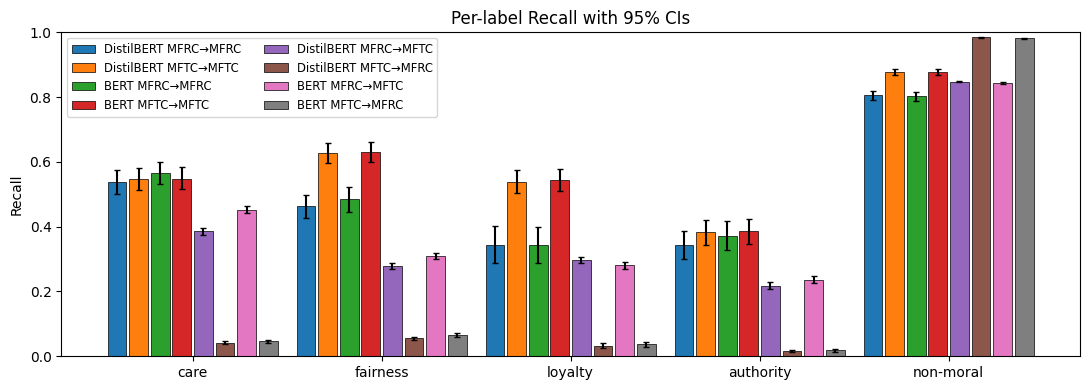

In [22]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from itertools import cycle

long = pd.read_csv("/content/per_label_metrics_with_ci.csv")

labels     = long["Label"].unique()
scenarios  = long["Scenario"].unique()
bar_width  = 0.8 / len(scenarios)
x_positions = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(11, 4))
offsets = cycle(np.linspace(-0.4, 0.4, len(scenarios)))

for scen in scenarios:
    subset = long[long["Scenario"] == scen]
    offs   = next(offsets)
    ax.bar(
        x_positions + offs,
        subset["Recall"],
        width=bar_width,
        label=scen,
        yerr=[
            subset["Recall"] - subset["Recall_lo"],
            subset["Recall_hi"] - subset["Recall"]
        ],
        capsize=2,
        linewidth=0.5,
        edgecolor="black"
    )

ax.set_xticks(x_positions, labels)
ax.set_ylim(0, 1)
ax.set_ylabel("Recall")
ax.set_title("Per-label Recall with 95% CIs")
ax.legend(ncol=2, fontsize="small")
plt.tight_layout()
plt.show()

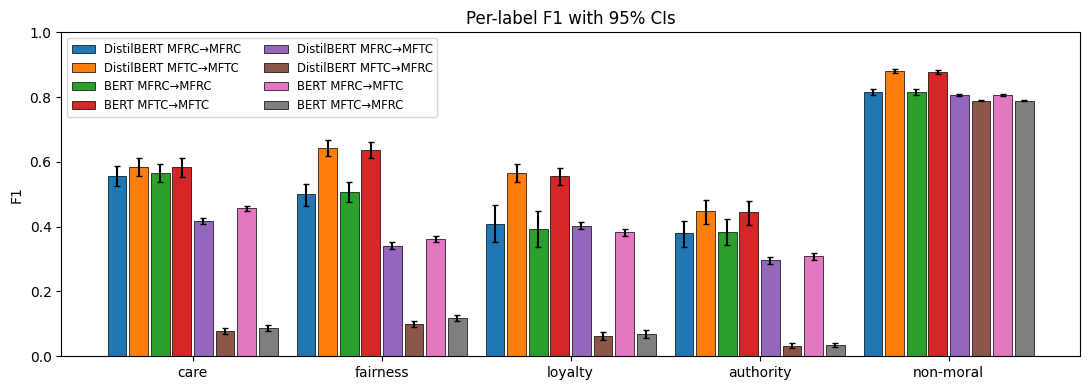

In [21]:
long = pd.read_csv("/content/per_label_metrics_with_ci.csv")

labels     = long["Label"].unique()
scenarios  = long["Scenario"].unique()
bar_width  = 0.8 / len(scenarios)
x_positions = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(11, 4))
offsets = cycle(np.linspace(-0.4, 0.4, len(scenarios)))

for scen in scenarios:
    subset = long[long["Scenario"] == scen]
    offs   = next(offsets)
    ax.bar(
        x_positions + offs,
        subset["F1"],
        width=bar_width,
        label=scen,
        yerr=[
            subset["F1"] - subset["F1_lo"],
            subset["F1_hi"] - subset["F1"]
        ],
        capsize=2,
        linewidth=0.5,
        edgecolor="black"
    )

ax.set_xticks(x_positions, labels)
ax.set_ylim(0, 1)
ax.set_ylabel("F1")
ax.set_title("Per-label F1 with 95% CIs")
ax.legend(ncol=2, fontsize="small")
plt.tight_layout()
plt.show()

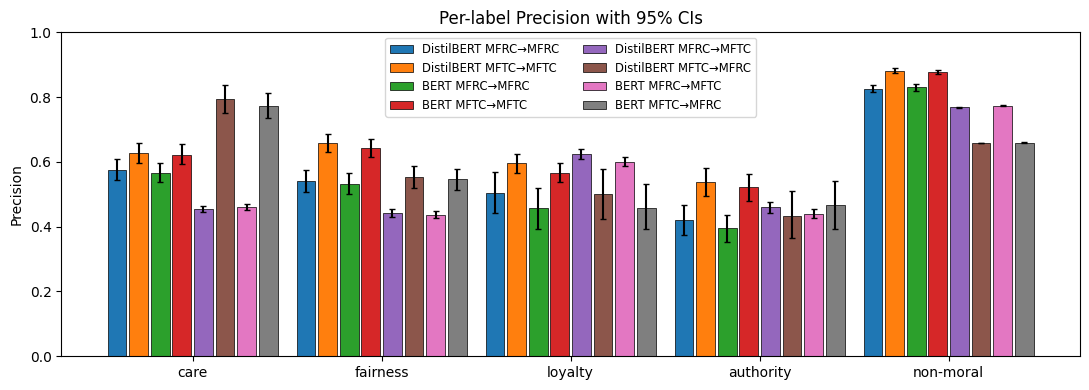

In [20]:
long = pd.read_csv("/content/per_label_metrics_with_ci.csv")

labels     = long["Label"].unique()
scenarios  = long["Scenario"].unique()
bar_width  = 0.8 / len(scenarios)
x_positions = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(11, 4))
offsets = cycle(np.linspace(-0.4, 0.4, len(scenarios)))

for scen in scenarios:
    subset = long[long["Scenario"] == scen]
    offs   = next(offsets)
    ax.bar(
        x_positions + offs,
        subset["Precision"],
        width=bar_width,
        label=scen,
        yerr=[
            subset["Precision"] - subset["Precision_lo"],
            subset["Precision_hi"] - subset["Precision"]
        ],
        capsize=2,
        linewidth=0.5,
        edgecolor="black"
    )

ax.set_xticks(x_positions, labels)
ax.set_ylim(0, 1)
ax.set_ylabel("Precision")
ax.set_title("Per-label Precision with 95% CIs")
ax.legend(ncol=2, fontsize="small")
plt.tight_layout()
plt.show()

**THIS PART WILL FOCUS ON THE FAIRNESS ANALYSIS USING FAIRLEARN AND NOVEL METRIC EXPLORATION FOR CROSS DOMAIN SCENARIOS: FAIRNESS GROUP ATTRIBUTE IS THE SOCIAL MEDIA DOMAIN ITSELF (TWITTER or REDDIT)**

In [24]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.2 MB/s eta 0:00:00


In [25]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
np.random.seed(42)

#Use the cross domain scenarios
scenario_pkls = [
    ("DistilBERT MFRC→MFTC", "/content/drive/MyDrive/test_results_distilbert_mfrc_mftc.pkl"),
    ("DistilBERT MFTC→MFRC", "/content/drive/MyDrive/test_results_distilbert_mftc_mfrc.pkl"),
    ("BERT MFRC→MFTC",       "/content/drive/MyDrive/test_results_bert_mfrc_mftc.pkl"),
    ("BERT MFTC→MFRC",       "/content/drive/MyDrive/test_results_bert_mftc_mfrc.pkl"),
]


In [27]:
domain_map = {"MFTC": "twitter", "MFRC": "reddit"}
labels = ["non-moral", "fairness", "care", "loyalty", "authority"]

In [28]:
def load_scenario(path, target_domain):
    df = pd.read_pickle(path)
    y_true = np.vstack(df["label_vec"].values)
    y_pred = np.vstack(df["pred_label_vec"].values)
    groups = np.array([target_domain] * y_true.shape[0])
    return y_true, y_pred, groups

def bootstrap_ci_label(metric_fn, y_true, y_pred, groups, B=300, alpha=0.05):
    """Bootstrap CI for a single-label metric."""
    n = len(y_true)
    stats = []
    for _ in range(B):
        idx = np.random.choice(n, size=n, replace=True)
        stats.append(metric_fn(
            y_true[idx],
            y_pred[idx],
            sensitive_features=groups[idx]
        ))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return lo, hi

In [29]:
def dp_fn(yt, yp, sensitive_features):
    return demographic_parity_difference(yt, yp, sensitive_features=sensitive_features)

def eo_fn(yt, yp, sensitive_features):
    return equalized_odds_difference(yt, yp, sensitive_features=sensitive_features)

In [30]:
records = []

for model in ["DistilBERT", "BERT"]:
    all_yt, all_yp, all_grp = [], [], []
    for name, path in scenario_pkls:
        if name.startswith(model):
            tgt = name.split("→")[1]
            dom = domain_map[tgt]
            yt, yp, grp = load_scenario(path, dom)
            all_yt.append(yt)
            all_yp.append(yp)
            all_grp.append(grp)

    Y_true = np.vstack(all_yt)
    Y_pred = np.vstack(all_yp)
    G      = np.concatenate(all_grp)

    for j, label in enumerate(labels):
        yt_j = Y_true[:, j]
        yp_j = Y_pred[:, j]

        dp = demographic_parity_difference(yt_j, yp_j, sensitive_features=G)
        eo = equalized_odds_difference(yt_j, yp_j, sensitive_features=G)
        dp_lo, dp_hi = bootstrap_ci_label(dp_fn, yt_j, yp_j, G)
        eo_lo, eo_hi = bootstrap_ci_label(eo_fn, yt_j, yp_j, G)

        records.append({
            "Model": model,
            "Label": label,
            "DP": dp,
            "DP_lo": dp_lo,
            "DP_hi": dp_hi,
            "EO": eo,
            "EO_lo": eo_lo,
            "EO_hi": eo_hi
        })

fairness_df = pd.DataFrame(records)
fairness_df.to_csv("/content/drive/MyDrive/fairness_across_domains_NEW.csv", index=False)

**Moral Foundation Consistency Score Calculation**

# For each model (DistilBERT, BERT), compute Moral Fairness Consistency (MFC) per moral label.
# MFC reflects how similarly models predict across domains (MFRC → MFTC and MFTC → MFRC).
# Bootstrapping is used to estimate 95% confidence intervals for each label's MFC score.

In [32]:
drive.mount('/content/drive')

np.random.seed(42)

scenario_pkls = {
    "DistilBERT MFRC→MFTC": "/content/drive/MyDrive/test_results_distilbert_mfrc_mftc.pkl",
    "DistilBERT MFTC→MFRC": "/content/drive/MyDrive/test_results_distilbert_mftc_mfrc.pkl",
    "BERT MFRC→MFTC": "/content/drive/MyDrive/test_results_bert_mfrc_mftc.pkl",
    "BERT MFTC→MFRC": "/content/drive/MyDrive/test_results_bert_mftc_mfrc.pkl"
}

labels = ["non-moral", "fairness", "care", "loyalty", "authority"]

def load_preds(path):
    df = pd.read_pickle(path)
    return np.vstack(df["pred_label_vec"].values)

#Bootstrap MFC per label
def bootstrap_mfc_per_label(yp_r2t, yp_t2r, B=1000, alpha=0.05):
    n_r, n_t = yp_r2t.shape[0], yp_t2r.shape[0]
    num_labels = yp_r2t.shape[1]
    results = []

    for j in range(num_labels):
        true_diff = abs(yp_r2t[:, j].mean() - yp_t2r[:, j].mean())
        base_mfc = 1 - true_diff
        stats = []

        for _ in range(B):
            idx_r = np.random.choice(n_r, size=min(n_r, n_t), replace=True)
            idx_t = np.random.choice(n_t, size=min(n_r, n_t), replace=True)
            diff = abs(yp_r2t[idx_r, j].mean() - yp_t2r[idx_t, j].mean())
            stats.append(1 - diff)

        lo, hi = np.percentile(stats, [100 * alpha / 2, 100 * (1 - alpha / 2)])
        results.append((round(base_mfc, 4), round(lo, 4), round(hi, 4)))

    return results

records = []

for model in ["DistilBERT", "BERT"]:
    yp_r2t = load_preds(scenario_pkls[f"{model} MFRC→MFTC"])
    yp_t2r = load_preds(scenario_pkls[f"{model} MFTC→MFRC"])

    mfc_per_label = bootstrap_mfc_per_label(yp_r2t, yp_t2r)

    for label, (mfc, lo, hi) in zip(labels, mfc_per_label):
        records.append({
            "Model": model,
            "Label": label,
            "MFC": mfc,
            "CI_Lower": lo,
            "CI_Upper": hi
        })

mfc_df = pd.DataFrame(records)
mfc_df.to_csv("/content/drive/MyDrive/mfc_per_label.csv", index=False)
print(mfc_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        Model      Label     MFC  CI_Lower  CI_Upper
0  DistilBERT  non-moral  0.9205    0.9179    0.9234
1  DistilBERT   fairness  0.9499    0.9472    0.9524
2  DistilBERT       care  0.9556    0.9537    0.9576
3  DistilBERT    loyalty  0.9666    0.9647    0.9684
4  DistilBERT  authority  0.7781    0.7741    0.7822
5        BERT  non-moral  0.9076    0.9047    0.9102
6        BERT   fairness  0.9451    0.9429    0.9478
7        BERT       care  0.9573    0.9552    0.9593
8        BERT    loyalty  0.9617    0.9599    0.9637
9        BERT  authority  0.7727    0.7681    0.7771


<ipython-input-8-3632210f6675>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


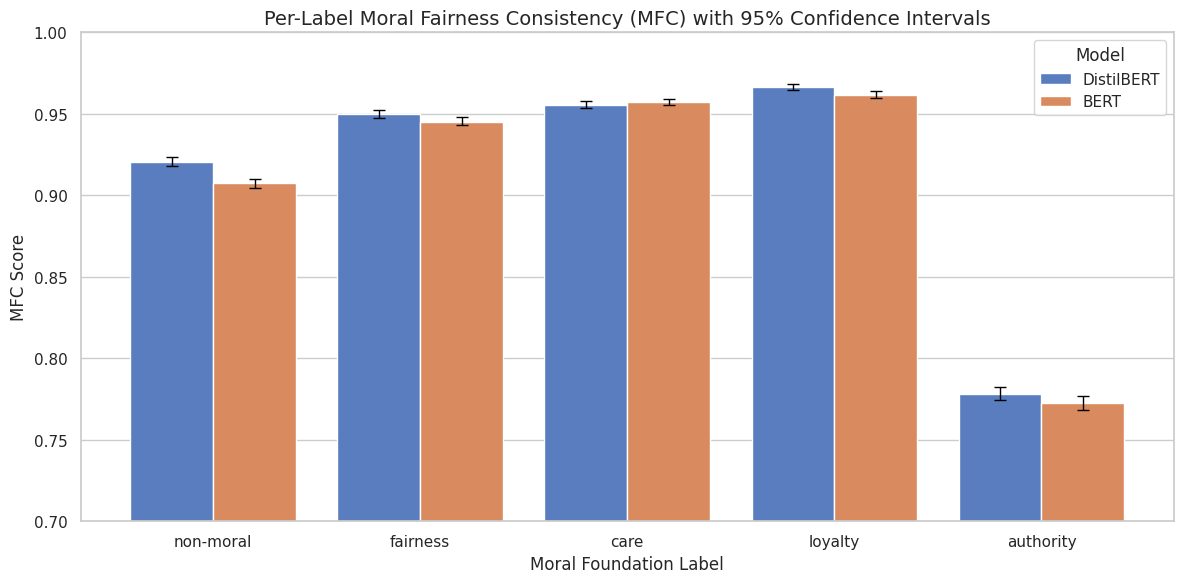

In [8]:
import seaborn as sns

mfc_df["CI_Lower_Err"] = mfc_df["MFC"] - mfc_df["CI_Lower"]
mfc_df["CI_Upper_Err"] = mfc_df["CI_Upper"] - mfc_df["MFC"]

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    data=mfc_df,
    x="Label",
    y="MFC",
    hue="Model",
    ci=None,
    capsize=0.1,
    palette="muted"
)

n_labels = mfc_df["Label"].nunique()
for i in range(len(mfc_df)):
    row = mfc_df.iloc[i]
    offset = -0.2 if row["Model"] == "DistilBERT" else 0.2
    ax.errorbar(
        x=i % n_labels + offset,
        y=row["MFC"],
        yerr=[[row["CI_Lower_Err"]], [row["CI_Upper_Err"]]],
        fmt='none',
        ecolor='black',
        capsize=4,
        lw=1
    )

plt.title("Per-Label Moral Fairness Consistency (MFC) with 95% Confidence Intervals", fontsize=14)
plt.ylabel("MFC Score")
plt.ylim(0.7, 1.0)
plt.xlabel("Moral Foundation Label")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

**HERE WE CONDUCT THE CORRELATION ANALYSIS USING SPEARMANS TEST**

In [16]:
from scipy.stats import spearmanr

#Load files containing the various metrics
mfc_df = pd.read_csv("/content/drive/MyDrive/mfc_per_label.csv")
fairness_df = pd.read_csv("/content/drive/MyDrive/fairness_across_domains_NEW.csv")
perf_df = pd.read_csv("/content/drive/MyDrive/per_label_metrics_with_ci_1000bs.csv")

#Extract Model from Scenario in perf_df
perf_df["Model"] = perf_df["Scenario"].str.extract(r"^(DistilBERT|BERT)")

#Merge on Model + Label
merged = mfc_df.merge(fairness_df, on=["Model", "Label"]).merge(perf_df, on=["Model", "Label"])

#Metrics to correlate with MFC
metrics_to_check = ["F1", "Precision", "Recall", "DP", "EO"]

#Compute correlations for each model separately
for model in ["BERT", "DistilBERT"]:
    subset = merged[merged["Model"] == model]
    print(f"\n Spearman Correlations for {model}")
    for metric in metrics_to_check:
        rho, pval = spearmanr(subset["MFC"], subset[metric])
        print(f"MFC vs {metric:9}: ρ = {rho:.4f}, p = {pval:.4f}")


=== Spearman Correlations for BERT ===
MFC vs F1       : ρ = -0.1042, p = 0.6619
MFC vs Precision: ρ = 0.0429, p = 0.8574
MFC vs Recall   : ρ = -0.1410, p = 0.5532
MFC vs DP       : ρ = -1.0000, p = 0.0000
MFC vs EO       : ρ = -0.9000, p = 0.0000

=== Spearman Correlations for DistilBERT ===
MFC vs F1       : ρ = -0.0920, p = 0.6998
MFC vs Precision: ρ = 0.1226, p = 0.6065
MFC vs Recall   : ρ = -0.0981, p = 0.6807
MFC vs DP       : ρ = -1.0000, p = 0.0000
MFC vs EO       : ρ = -0.9000, p = 0.0000


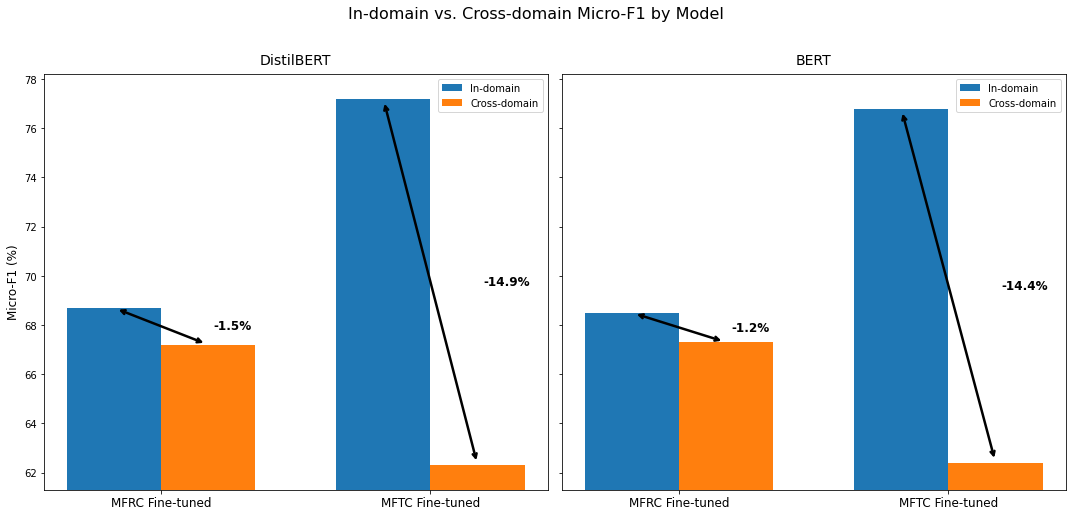

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Data for each model
categories = ['MFRC Fine-tuned', 'MFTC Fine-tuned']
distil_in = [68.7, 77.2]
distil_cross = [67.2, 62.3]
bert_in = [68.5, 76.8]
bert_cross = [67.3, 62.4]

x = np.arange(len(categories))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

for ax, model_name, in_vals, cross_vals in zip(
        axes,
        ['DistilBERT', 'BERT'],
        [distil_in, bert_in],
        [distil_cross, bert_cross],
    ):
    ax.bar(x - width/2, in_vals, width, label='In-domain')
    ax.bar(x + width/2, cross_vals, width, label='Cross-domain')
    ax.set_title(model_name, fontsize=14, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12)

    for i in range(len(categories)):
        y1 = in_vals[i]
        y2 = cross_vals[i]
        drop_pct = y1 - y2
        ax.annotate(
            '', 
            xy=(x[i] - width/2, y1), 
            xytext=(x[i] + width/2, y2),
            arrowprops=dict(arrowstyle='<->', lw=2.5, color='black', shrinkA=5, shrinkB=5)
        )
        mid_y = (y1 + y2) / 2
        ax.text(
            x[i] + width/2 + 0.02, 
            mid_y, 
            f'-{drop_pct:.1f}%', 
            va='center', 
            ha='left',
            fontsize=12,
            fontweight='bold',
            color='black'
        )

axes[0].set_ylabel('Micro-F1 (%)', fontsize=12)
fig.suptitle('In-domain vs. Cross-domain Micro-F1 by Model', fontsize=16, y=1.02)

min_drop = min(min(distil_cross), min(bert_cross)) - 1
max_in = max(max(distil_in), max(bert_in)) + 1
axes[0].set_ylim(min_drop, max_in)

for ax in axes:
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()